# Environmental and Racial justice in NYC:
### Does minorities and low income communities have less access to green spaces and more exposure to air pollution?

### 1. Introduction
Environmental inequality in the U.S. has a long history closely linked to physical community segregation and unequal distribution of pollution sources and environmental
amenities. This includes redlining, discriminatory zoning, and other practices that have resulted in the concentration of low-income and minority communities. Even though, economically speaking, these low income communities sort themselves into these areas, as urban planners, it is also our responsibility to ensure that these communities are not being disproportionately affected by environmental hazards.

These environmental hazards include exposure to air pollution and lack of access to green spaces or trees. Exposure to air pollution has been linked to many health problems, including asthma, heart disease, and lung cancer. On the other hand, access to green spaces has been linked to better mental health, lower stress levels, and lower rates of depression.

This study aims at identify the pattern of environmental inequality in NYC, if any.

### 2. Data collection, preparation, and cleaning
In this study, we will be using the following datasets:
1. ACS 2018 5-year estimates to get the demographic data of NYC census tracts

2. NYC 2018 tree census data to get the tree count, density, as a proxy of the greenary amenities in NYC

3. Google Street View API to get the street view images of NYC census tracts - and calculate the GVI based on the images

4. Air quality data from NYC Open Data portal to assess the air quality in NYC census tracts

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# acs data
acs = pd.read_csv('ACS.csv')
acs.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,36005000100,"Census Tract 1, Bronx County, New York",ACSSF,ny,140,0,3608,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,"Census Tract 2, Bronx County, New York",ACSSF,ny,140,0,3609,NaN,NaN,NaN,...,833,450,1340,228,384,354,167,89,0,118
2,36005000400,"Census Tract 4, Bronx County, New York",ACSSF,ny,140,0,3610,NaN,NaN,NaN,...,1056,727,2110,402,602,509,426,121,50,0
3,36005001600,"Census Tract 16, Bronx County, New York",ACSSF,ny,140,0,3611,NaN,NaN,NaN,...,1032,738,2153,456,630,338,329,281,79,40
4,36005001901,"Census Tract 19.01, Bronx County, New York",ACSSF,ny,140,0,3612,NaN,NaN,NaN,...,398,208,784,259,282,74,105,39,12,13


For ACS data, we would like to aggregate the block group level data to the census tract level to match the other datasets. We will be using the following variables:
1. __Race: Hispanic or Latino by Race (Collapsed Version)__
         Universe:  Total Population
         Name:      B04001
         Variables:
            B04001_001:   Total Population:
            B04001_002:      Not Hispanic or Latino:
            B04001_003:         White Alone
            B04001_004:         Black or African American Alone
            B04001_005:         American Indian and Alaska Native Alone
            B04001_006:         Asian Alone
            B04001_007:         Native Hawaiian and Other Pacific Islander Alone
            B04001_008:         Some Other Race Alone
            B04001_009:         Two or More Races
            B04001_010:      Hispanic or Latino


2. __Income: Household Income (In <DollarYear> Inflation Adjusted Dollars) (Collapsed Version)__
         Universe:  Households
         Name:      B14001
         Variables:
            B14001_001:   Households:
            B14001_002:      Less than $25,000
            B14001_003:      $25,000 to $49,999
            B14001_004:      $50,000 to $74,999
            B14001_005:      $75,000 to $99,999
            B14001_006:      $100,000 or More

3. __Rent burden: Residents Paying More Than 30% or at least 50% of Income on Rent__
          Universe:  Renter-Occupied Housing Units
          Name:      B18002
          Variables:
             B18002_001:   Renter-Occupied Housing Units:
             B18002_002:      30 to 49 Percent
             B18002_003:      50 percent or More

In [4]:
# cleanning the acs data, and to census tract level
acs_filtered = pd.DataFrame()
acs_filtered['Geo_FIPS'] = acs['Geo_FIPS'].astype(str)
acs_filtered['Geo_QName'] = acs['Geo_QName']
# -----
# race info
"""
Hispanic or Latino by Race (Collapsed Version)
         Universe:  Total Population
         Name:      B04001
         Variables:
            B04001_001:   Total Population:
            B04001_002:      Not Hispanic or Latino:
            B04001_003:         White Alone
            B04001_004:         Black or African American Alone
            B04001_005:         American Indian and Alaska Native Alone
            B04001_006:         Asian Alone
            B04001_007:         Native Hawaiian and Other Pacific Islander Alone
            B04001_008:         Some Other Race Alone
            B04001_009:         Two or More Races
            B04001_010:      Hispanic or Latino
"""
acs_filtered['Total_Pop'] = acs['SE_B04001_001']
acs_filtered['White_Pct'] = acs['SE_B04001_003'] / acs['SE_B04001_001']
acs_filtered['Black_Pct'] = acs['SE_B04001_004'] / acs['SE_B04001_001']
acs_filtered['Asian_Pct'] = acs['SE_B04001_006'] / acs['SE_B04001_001']
acs_filtered['Hispanic_Pct'] = acs['SE_B04001_010'] / acs['SE_B04001_001']
# ----- income
"""
      6. Household Income (In <DollarYear> Inflation Adjusted Dollars) (Collapsed Version)
         Universe:  Households
         Name:      B14001
         Variables:
            B14001_001:   Households:
            B14001_002:      Less than $25,000
            B14001_003:      $25,000 to $49,999
            B14001_004:      $50,000 to $74,999
            B14001_005:      $75,000 to $99,999
            B14001_006:      $100,000 or More


      7. Median Household Income (In <DollarYear> Inflation Adjusted Dollars)
         Universe:  Households
         Name:      A14006
         Variables:
            A14006_001:   Median Household Income (In 2020 Inflation Adjusted Dollars)
"""
acs_filtered['Median_hh_Income'] = acs['SE_A14006_001']
# ----- rent burden
"""
      11. Residents Paying More Than 30% or at least 50% of Income on Rent
          Universe:  Renter-Occupied Housing Units
          Name:      B18002
          Variables:
             B18002_001:   Renter-Occupied Housing Units:
             B18002_002:      30 to 49 Percent
             B18002_003:      50 percent or More
"""
acs_filtered['Rent_30_50pct'] = acs['SE_B18002_002'] / acs['SE_B18002_001']
acs_filtered['Rent_50+pct'] = acs['SE_B18002_003'] / acs['SE_B18002_001']

In [5]:
acs_filtered.head()

,Geo_FIPS,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct
0,36005000100,"Census Tract 1, Bronx County, New York",6600,0.123788,0.490000,0.025909,0.350758,NaN,NaN,NaN
1,36005000200,"Census Tract 2, Bronx County, New York",4167,0.018479,0.235181,0.027598,0.706263,68000.0,0.200355,0.329787
2,36005000400,"Census Tract 4, Bronx County, New York",5684,0.065271,0.169775,0.015306,0.729768,93155.0,0.244207,0.165775
3,36005001600,"Census Tract 16, Bronx County, New York",5917,0.038702,0.335643,0.010647,0.563630,34766.0,0.375396,0.164731
4,36005001901,"Census Tract 19.01, Bronx County, New York",1910,0.135602,0.319372,0.000000,0.538743,61711.0,0.185567,0.293814


---
For tree census data, we would like to aggregate the block level data to the census tract level to match the other datasets.

In [6]:
# tree density
# notice that this is at block group level -> FIPS = FIPS[:-1]
tree = pd.read_csv('tree_density.csv')
tree_filtered = pd.DataFrame()
tree_filtered['Geo_FIPS'] = tree['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
tree_filtered['tree_density'] = tree['NYC_Block_group_tree_temp_pollution_Tree_density']
tree_filtered['tree_num'] = tree['NYC_Block_group_tree_temp_pollution_Number_of_trees']
tree_filtered.head()

,Geo_FIPS,tree_density,tree_num
0,36005017500,0.000149,38
1,36005014100,0.000048,29
2,36005014500,0.000103,52
3,36005007500,0.000194,228
4,36005041800,0.000060,91


---
The Green View Index (GVI) is calculated from the Google Street View (GSV) images using Semantic Image Segmentation. GVI is a representation of the residents’ eye-level
perception of urban greenery.
We used the road network and boundary shapefile of the City provided by NYC Open Data as the input to determine which points to sample GVI from. Using the Python libraries
Fiona and Shapely, we created 140,000 points along the street network with a sampling distance of 200 meters. To make the input points more accurately reflect ordinary residents’ perceived
greenness, and to meet our constraints in computational power and budget, we filtered out the points that are less accessible: points on highways or in tunnels were removed, for example.

We retrieved 496,158 images from 82,693 sampling points, and averaged the GVIs to each census tract.

In [ ]:
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))


# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

def seg(img):
    pil_image = PIL.Image.open(img).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    return pred
    #=====================Visualization=======================================#
    #visualize_result(img_original, pred)


    # Top classes in answer
    #predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    #for c in predicted_classes[:10]:
        #visualize_result(img_original, pred, c)

def GVI_calculation(img):
    resolution = 400*400
    veg_code = {
        'tree' : 4,
        'grass' : 9,
        'palm' : 72}
    pred = seg(img)
    pixel_count = 0
    for i in greenIndex.values():
        pixel_count += len(np.where(pred == i)[0]) # accumulate pixel count
    GVI_Pct = pixel_count/resolution*100
    return GVI_Pct



Sample GSV images fetched

![](pic/1.jpg)


Predicted vegetation result created from the MIT ADE20K scene parsing dataset

![](pic/2.jpg)

In [7]:
# GVI
gvi = pd.read_csv('GVI.csv')
gvi_filtered = pd.DataFrame()
gvi_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
gvi_filtered['GVI'] = gvi['mean_greenview_1']
gvi_filtered.head()

,Geo_FIPS,GVI
0,36005017500,15.503791
1,36005014100,13.517106
2,36005014500,18.115964
3,36005007500,20.787891
4,36005041800,15.575710


---
Air quality data includes the concentration of nitrogen dioxide (NO2), fine particulate matter (PM2.5), nitric oxide (NO), and ozone (O3). Unfortunately, due to the low spatial resolution
of the pollution data, we were only able to obtain averages for 4,065 block groups out of the 6,287 land census block groups in the City.


In [8]:
# air quality
pollution_filtered = pd.DataFrame()
pollution_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
pollution_filtered['PM2.5'] = gvi['NYC_Block_group_tree_temp_pollution_Mean_PM2']
pollution_filtered.head()

,Geo_FIPS,PM2.5
0,36005017500,6.074496
1,36005014100,6.073939
2,36005014500,6.198496
3,36005007500,6.040218
4,36005041800,5.950134


## Data aggregation
We would like to plot the data for further investigation. To do so, we need to merge the dataframes together. We will use the Geo_FIPS column as the key to merge the dataframes.
We also included the geometry column from the census tract data to plot the data on the map.

In [9]:
# merge data

# census tract
ct = gpd.read_file('ct.json')

aggregate = gpd.GeoDataFrame()
aggregate['geometry'] = ct['geometry']
aggregate['Geo_FIPS'] = ct['GEOID'].astype(str)
aggregate['BoroName'] = ct['BoroName']
aggregate['NTAName'] = ct['NTAName']
# -----
# ACS data
aggregate = aggregate.merge(acs_filtered, on='Geo_FIPS')
# -----
# tree density
aggregate = aggregate.merge(tree_filtered, on='Geo_FIPS')
# -----
# gvi
aggregate = aggregate.merge(gvi_filtered, on='Geo_FIPS')
# -----
# air quality
aggregate = aggregate.merge(pollution_filtered, on='Geo_FIPS')
aggregate.head()

,geometry,Geo_FIPS,BoroName,NTAName,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct,tree_density,tree_num,GVI,PM2.5
0,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",36061000100,Manhattan,The Battery-Governors Island-Ellis Island-Libe...,"Census Tract 1, New York County, New York",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,NaN,5.743412
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,6.532890
2,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,NaN
3,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,6.532890
4,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,NaN


# 3. Exploratory Data Analysis

# 3.1 Correlation between variables

<AxesSubplot: >

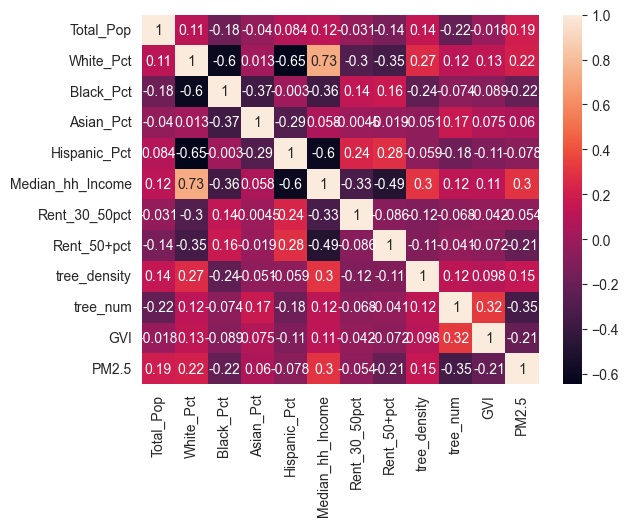

In [10]:
# cov matrix plot
sns.heatmap(aggregate.corr(), annot=True)

# TODO: Include the distance to the 3 nearest park